In [1]:
import numpy as np
import matplotlib.pyplot as plt
import graphlearning as gl
from scipy.optimize import minimize, LinearConstraint
import sklearn.datasets as datasets
import scipy
from numba import jit, njit, prange
import time

## Cheat sheet
$$I[u] = \frac{1}{2p} \sum_{i,j=1}^n w_{i j} | \nabla u(x_i,x_j) |^p - \sum_{j=1}^m(y_j - \bar{y}) \cdot u(x_j)$$
where $$ \nabla u(x_i, x_j) = u(x_j) - u(x_i) $$

$$ \frac{\partial I}{\partial u_{rs}} = \sum_{i=1}^n w_{ir} |\nabla u (x_i, x_r)|^{p-2}(u_{rs} - u_{is}) - B_{rs} $$
where $B \in \mathbb{R}^{n \times k}, B_{rs} = y_{rs} - \bar{y}$ when $r \leq m$ and $B_{rs} = 0$ when $r>m$.

And for $p = 2$:
$$ \frac{\partial I_2}{\partial u_{rs}} = \sum_{i=1}^n w_{ir}(u_{rs} - u_{is}) - B_{rs} $$
where $B \in \mathbb{R}^{n \times k}, B_{rs} = y_{rs} - \bar{y}$ when $r \leq m$ and $B_{rs} = 0$ when $r>m$.

$$ \frac{\partial^2 I}{\partial u_{rs} \partial u_{r's'}} = (p-2) \sum_{i=1}^n w_{ir} | \nabla u(x_i,x_r) |^{p-4} (u_{rs'} - u_{is'})(\delta_{r r'} - \delta_{i r'})(u_{rs} - u_{is}) + \delta_{s s'} \sum_{i=1}^n w_{ir} | \nabla u(x_i,x_r) |^{p-2} (\delta_{r r'} - \delta_{i r'})$$

And for $p = 2$:
$$ \frac{\partial^2 I_2}{\partial u_{rs} \partial u_{r's'}} = \delta_{ss'}\sum_{i=1}^n w_{ir}(\delta_{rr'} - \delta_{ir'}) $$

And for $p=4$:

$$ \frac{\partial^2 I_4}{\partial u_{rs} \partial u_{r's'}} = 2 \sum_{i=1}^n w_{ir} (u_{rs'} - u_{is'})(\delta_{r r'} - \delta_{i r'})(u_{rs} - u_{is}) + \delta_{s s'} \sum_{i=1}^n w_{ir} | \nabla u(x_i,x_r) |^{p-2} (\delta_{r r'} - \delta_{i r'})$$

## Core functions

In [2]:
# Calculates vector of degrees for the weight matrix W
# W: (n,k) numpy array
@jit(forceobj=True)
def degrees(W):
    return W.sum(axis = 1)

# Example
# Calculates degrees of equilateral triangle
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# print(degrees(W))

"""
Computes the gradient of u
u: (n,k) matrix

Returns:
gradu: (n, n, k)

where gradu[i, j, l] = u[j,l]-u[i,l]
"""
@jit(forceobj=True)
def graph_grad(u):
    gradu = -u[:, np.newaxis] + u

    return gradu

# # Example:
# u = np.arange(6).reshape(3,2)
# print("u is\n", u)
# print("\nAnd gradu is")
# for i in range(u.shape[0]):
#     for j in range(u.shape[1]):
#         print(graph_grad(u)[i,j], end = "\t\t")
#     print()

"""
u_flattened: n*k matrix
W: weight matrix
y: (m,k) matrix
idx = vector of labelled indices
p = p constant for laplace operator
"""
@jit(forceobj=True)
def penergy(u_flattened, W, idx, y, p):
    k = y.shape[1]
    n = int(u_flattened.size/k)
    u = u_flattened.reshape((n,k))
    gradu = graph_grad(u)
    y_bar = (1/y.shape[0]) * y.sum(axis = 0)
    
    first_summand = (1/(2*p)) * (W * (np.apply_along_axis(np.linalg.norm, 2, gradu) ** p)).sum()
    second_summand = np.sum( (y - y_bar) * u[idx] )

    return first_summand - second_summand

# ## Example (see pdf)
# u = np.array([[1,0], [0,1], [1/2, 1/2]])
# print(graph_grad(u))
# y = np.array([[1,0], [0,1]])
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# idx = [0, 1]
# p = 2

# #print(np.apply_along_axis(np.linalg.norm, 2, graph_grad(u)))
# print("2-energy is", penergy(u, W, idx, y, 2))
# print("3-energy is", penergy(u, W, idx, y, 3))

"""
Returns the jacobian of the p-energy
Note that it is now used anywhere.
"""
@jit(forceobj=True)
def jacobian(u_flattened, W, idx, y, p):
    n = W.shape[0]
    k = u_flattened.size//n
    m = y.shape[0]

    u = u_flattened.reshape((n,k))
    gradu = graph_grad(u)
    y_bar = y.sum(axis = 0)/m

    jacob = np.zeros((n, k))
    jacob[idx] = -y + y_bar # First add the derivative of the second summand
    
    
    for r in range(n):
        for s in range(k):
            jacob[r,s] += (W[:, r] * ( np.apply_along_axis(np.linalg.norm, 2, gradu)[:, r]**(p-2) ) * (u[r,s] - u[:, s])).sum()

    return jacob.flatten()

## Example
# y = np.array([[1,0], [0,1]])
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# idx = [0, 1]
# n = 3
# k = 2
# m = 2
# p = 3
# u = np.random.random(size = (n,k))

# print(jacobian(u.flatten(), W, idx, y, p))

# r = s = 0
# gradu = graph_grad(u)
# y_bar = y.sum(axis = 0)/m

# scipy.optimize.check_graph_grad(penergy, jacobian, u.flatten(), W, idx, y, p)
@jit(forceobj=True)
def vectorized_jacobian(u_flattened, W, idx, y, p):
    n = W.shape[0]
    k = u_flattened.size//n
    m = y.shape[0]    
    
    u = u_flattened.reshape((n,k))
    gradu = graph_grad(u)
    normed_gradu = np.apply_along_axis(np.linalg.norm, 2, gradu)
    y_bar = y.sum(axis = 0)/m
    
    if p > 2:
        # ... = w*normed_gradu**(p-2)
        a1 = W * (normed_gradu**(p-2)) + np.zeros((k, n, n)) # a1[s,i,r] = ...[i, r]
        A = np.transpose(a1, (1, 2, 0)) # A[i,r, s] = ...[i, r]

        u1 = np.zeros( (n, n, k) ) + u #u1[i, r, s] = u[r, s]

        u21 = np.zeros( (n,n,k) ) + u # u21[r, i, s] = u[i, s]
        u2 = np.swapaxes(u21, 0, 1) # u2[i, r, s] = u[i, s]

        C = u1 - u2

        B = np.zeros( (n, k) )
        B[idx] = y - y_bar

        jac = (A * C).sum(axis = 0) - B
    
    elif p == 2:
        a1 = W + np.zeros((k, n, n)) # a1[s,i,r] = W[i, r]
        A = np.transpose(a1, (1, 2, 0)) # A[i, r, s] = W[i, r]
        
        u1 = np.zeros( (n, n, k) ) + u #u1[i, r, s] = u[r, s]

        u21 = np.zeros( (n,n,k) ) + u # u2[r, i, s] = u[i, s]
        u2 = np.swapaxes(u21, 0, 1)

        C = u1 - u2

        B = np.zeros( (n, k) )
        B[idx] = y - y_bar
            
        jac = (A * C).sum(axis = 0) - B
    
    return jac.flatten()
    
# # Testing vectorized jacobian
# p = 6
# n = 15
# k = 2

# X,labels = datasets.make_moons(n_samples=n,noise=0.1)
# W = gl.weightmatrix.knn(X,10).toarray()
# train_ind = gl.trainsets.generate(labels, rate=5)
# train_labels = labels[train_ind]
# m = train_ind.size

# y = np.zeros((m, k))
# for i in range(train_ind.size):
#     y[i] = euclidean_basis(train_labels[i], k)
    

# u = np.random.random(size = (n,k))

# scipy.optimize.check_grad(penergy, vectorized_jacobian, u.flatten(), W, train_ind, y, p)

"""
Returns the hessian of the p-energy
Argunents
"""
@jit(forceobj = True, parallel=True)
def old_hessian(u_flattened, W, idx, y, p):
    n = W.shape[0]
    k = u_flattened.size//n
    m = y.shape[0]

    u = u_flattened.reshape((n,k))
    gradu = graph_grad(u)
    normed_gradu = np.apply_along_axis(np.linalg.norm, 2, gradu)
    hess = np.zeros((n,k,n,k))
    
    D = np.subtract.outer(u, u)
    
    for r in prange(n):
        for rr in prange(n):
            for s in prange(k):
                for ss in prange(k):
                    if r == rr:
                        hess += (p-2) * ((W * normed_gradu**(p-4))[:, r] * (u[r, ss] - u[:, ss]) ).sum()
                    hess -= (p-2) * (W * normed_gradu**(p-4))[rr, r] * D[r, ss, rr, ss]
                    if r == rr and s == ss:
                        hess += ((W * normed_gradu**(p-2))[:, r]).sum()
                    if s == ss:
                        hess += (W * (normed_gradu) ** (p-2))[rr, r]
    return hess.reshape(n, k, -1).reshape(n*k, -1)

@jit(forceobj = True, parallel=True)
def slow_hessian(u_flattened, W, idx, y, p):
    n = W.shape[0]
    k = u_flattened.size//n
    m = y.shape[0]

    u = u_flattened.reshape((n,k))
    gradu = graph_grad(u)
    normed_gradu = np.apply_along_axis(np.linalg.norm, 2, gradu)
    normed_gradu_p_4 = normed_gradu**(p-4)
    normed_gradu_p_2 = normed_gradu**(p-2)
    hess = np.zeros((n,k,n,k))
    
    A = np.subtract.outer(u, u) # A[a, b, c, d] = u[a,b] - u[c,d]
    B = np.substract.outer(np.eye(n), np.eye(n)) # B[a, b, c, d] = I[a,b] - I[c,d]
    C = np.eye(k)
    
    for r in prange(n):
        for rr in prange(n):
            for s in prange(k):
                for ss in prange(k):
                    hess[r,s,rr,ss] += W[i, r] * normed_gradu_p_4 * A[r, ss, i, ss] * B[r, rr, i, rr] * A[r, s, i, s] + C[s, ss] * W[i,r] * normed_gradu_p_2 * B[r, rr, i, rr]
    
    return hess.reshape(n, k, -1).reshape(n*k, -1)


@jit(forceobj=True, parallel = True)
def vectorized_hessian(u_flattened, W, idx, y, p):
    n = W.shape[0]
    k = u_flattened.size//n
    m = y.shape[0]

    u = u_flattened.reshape((n,k))
    gradu = graph_grad(u)
    normed_gradu = np.apply_along_axis(np.linalg.norm, 2, gradu)
    eye_n = np.eye(n)
    eye_k = np.eye(k)
    
    if p == 2:
        e1 = np.zeros((n, n, k, k)) + eye_k # e1[r,rr,s,ss] = I[s,ss]
        E = np.transpose(e1, (0, 2, 1, 3)) #E[r,s,rr,ss] = I[s,ss]
        
        a1 = W + np.zeros( (k, n, k, n, n) ) # a1[s, rr, ss, i, r] = W[i, r]
        A = np.transpose(a1, (3, 4, 0, 1, 2)) # A[i, r, s, rr, ss] = W[i, r]
        
        c11 = eye_n + np.zeros((n, k, k, n, n)) #c11[i, s, ss, r, rr] = I[r,rr]
        c1 = np.transpose(c11, (0, 3, 1, 4, 2)) #c1[i, r, s, rr, ss] = I[r,rr]

        c21 = eye_n + np.zeros((n, k, k, n, n)) #c21[r, s, ss, i, rr] = I[i, rr]
        c2 = np.transpose(c21, (3, 0, 1, 4, 2)) #c2[i, r, s, rr, ss] = I[i, rr]

        C = c1 - c2 # C[i,r,s,rr,ss] = I[r,rr] - I[i,rr]
        
        hess = E * (A * C).sum(axis = 0)
        
        return hess.reshape(n, k, -1).reshape(n*k, -1)
    
    elif p == 4:
        a1 = W + np.zeros( (k, n, k, n, n) ) # a1[s, rr, ss, i, r] = W[i, r]
        A = np.transpose(a1, (3, 4, 0, 1, 2)) # A[i, r, s, rr, ss] = W[i, r]
        
        u11 = u + np.zeros((n, n, k, n, k)) # u11[i,rr,ss,r,s] = u[r,s]
        u1 = np.transpose(u11, (0, 3, 4, 1, 2)) # u1[i,r,s,rr,ss] = u[r,s]

        u21 = u + np.zeros((n, k, n, n, k)) # u21[r,s,rr,i,ss] = u[i,ss]
        u2 = np.transpose(u21, (3, 0, 1, 2, 4)) # u2[i,r,s,rr,ss] = u[i,ss]

        B = u1 - u2 # B[i,r,s,rr,ss] = u[r,s] - u[i,ss]
        
        c11 = eye_n + np.zeros((n, k, k, n, n)) #c11[i, s, ss, r, rr] = I[r,rr]
        c1 = np.transpose(c11, (0, 3, 1, 4, 2)) #c1[i, r, s, rr, ss] = I[r,rr]

        c21 = eye_n + np.zeros((n, k, k, n, n)) #c21[r, s, ss, i, rr] = I[i, rr]
        c2 = np.transpose(c21, (3, 0, 1, 4, 2)) #c2[i, r, s, rr, ss] = I[i, rr]

        C = c1 - c2 # C[i,r,s,rr,ss] = I[r,rr] - I[i,rr]
        
        u31 = u + np.zeros((n, n, k, n, k)) #u31[r, rr, ss, i, s] = u[i,s]
        u3 = np.transpose(u31, (3, 0, 4, 1, 2)) #u3[i, r, s, rr, ss] = u[i,s]

        D = u1 - u3 # D[i,r,s,rr,ss] = u[r,s] - u[i,s]

        e1 = np.zeros((n, n, k, k)) + eye_k # e1[r,rr,s,ss] = I[s,ss]
        E = np.transpose(e1, (0, 2, 1, 3)) #E[r,s,rr,ss] = I[s,ss]
        
        # ... = W * (normed_gradu**(p-2))
        f1 = np.zeros((k, n, k, n, n)) + W * (normed_gradu**(p-2)) # f1[s, rr, ss, i, r] = ...[i,r]
        F = np.transpose(f1, (3,4,0,1,2)) # F[i, r, s, rr, ss] = ...[i,r]
        
        first_summand = 2 * (A * B * C * D).sum(axis = 0)
        second_summand = E * (F * C).sum(axis = 0)
        hess = first_summand + second_summand

        return hess.reshape(n, k, -1).reshape(n*k, -1)
        
    else:
        # ... = W * (normed_gradu ** (p-4))
        a1 = W * (normed_gradu ** (p-4)) + np.zeros( (k, n, k, n, n) ) # a1[s, rr, ss, i, r] = ...[i, r]
        A = np.transpose(a1, (3, 4, 0, 1, 2)) # A[i, r, s, rr, ss] = ...[i, r]

        u11 = u + np.zeros((n, n, k, n, k)) # u11[i,rr,ss,r,s] = u[r,s]
        u1 = np.transpose(u11, (0, 3, 4, 1, 2)) # u1[i,r,s,rr,ss] = u[r,s]

        u21 = u + np.zeros((n, k, n, n, k)) # u21[r,s,rr,i,ss] = u[i,ss]
        u2 = np.transpose(u21, (3, 0, 1, 2, 4)) # u2[i,r,s,rr,ss] = u[i,ss]

        B = u1 - u2 # B[i,r,s,rr,ss] = u[r,s] - u[i,ss]

        c11 = eye_n + np.zeros((n, k, k, n, n)) #c11[i, s, ss, r, rr] = I[r,rr]
        c1 = np.transpose(c11, (0, 3, 1, 4, 2)) #c1[i, r, s, rr, ss] = I[r,rr]

        c21 = eye_n + np.zeros((n, k, k, n, n)) #c21[r, s, ss, i, rr] = I[i, rr]
        c2 = np.transpose(c21, (3, 0, 1, 4, 2)) #c2[i, r, s, rr, ss] = I[i, rr]

        C = c1 - c2 # C[i,r,s,rr,ss] = I[r,rr] - I[i,rr]

        u31 = u + np.zeros((n, n, k, n, k)) #u31[r, rr, ss, i, s] = u[i,s]
        u3 = np.transpose(u31, (3, 0, 4, 1, 2)) #u3[i, r, s, rr, ss] = u[i,s]

        D = u1 - u3 # D[i,r,s,rr,ss] = u[r,s] - u[i,s]

        e1 = np.zeros((n, n, k, k)) + eye_k # e1[r,rr,s,ss] = I[s,ss]
        E = np.transpose(e1, (0, 2, 1, 3)) #E[r,s,rr,ss] = I[s,ss]

        # ... = W * (normed_gradu**(p-2))
        f1 = np.zeros((k, n, k, n, n)) + W * (normed_gradu**(p-2)) # f1[s, rr, ss, i, r] = ...[i,r]
        F = np.transpose(f1, (3,4,0,1,2)) # F[i, r, s, rr, ss] = ...[i,r]

        first_summand = (p-2) * (A * B * C * D).sum(axis = 0)
        second_summand = E * (F * C).sum(axis = 0)
        hess = first_summand + second_summand

        return hess.reshape(n, k, -1).reshape(n*k, -1)

"""
Returns the ith vector of the usual basis of R^k
Index starts at 0
"""
@jit(forceobj=True)
def euclidean_basis(i, k):
    eye = np.eye(k)
    return eye[i]

# Example
# print(euclidean_basis(0, 4))
# print(euclidean_basis(2, 4))

# Returns the labels that u predicts
@jit(forceobj=True)
def predict(u):
    return np.argmax(u, axis = 1)

# Solves the p-poisson equation on a graph with weight matrix W
# and labels y on the elements with indices idx
# using gradient descent
@jit(forceobj=True)
def gradient_ppoisson(W, idx, y, p):
    d = degrees(W)
    n = W.shape[0]
    k = y.shape[1]
    eye = np.eye(k)

    constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
    linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
    
    res = minimize(penergy, x0 = np.zeros(n * k), args = (W, idx, y, p), method = 'trust-constr', constraints = linear_constraint)
    u = res.x.reshape(n,k)
    
    return u

# ############## Toy example using gradient descent
# y = np.array([[1,0], [0,1]])
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# idx = [0, 1]
# p = 2

# u = gradient_ppoisson(W, idx, y, p)
# print("Minimizer:\n", u)
# print("Energy of minimizer:", penergy(u, W, idx, y, p))
# print("Negative Laplacian values:", 2*u[0]-u[1]-u[2], 2*u[1]-u[0]-u[2], 2*u[2]-u[0]-u[1], sep="\n")
# print("Labels:", predict(u))

# ############## Toy example using GraphLearn
# y = np.array([[1,0], [0,1]])
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# d = degrees(W)
# idx = [0, 1]
# n = 3
# k = 2
# p = 2

# model = gl.ssl.poisson(W)
# u = model.fit(idx, np.array([0, 1]))
# # print(2*u[0]-u[1]-u[2])
# # print(2*u[1]-u[0]-u[2])
# # print(2*u[2]-u[0]-u[1])
# # print(u[0] + u[1] + u[2])
# print("GraphLearn solution: \n", u)

# # Toy example using custom implementation
# my_u = gradient_ppoisson(W, idx, y, p)
# print("Custom solution: \n", my_u)

"""
W : (n,n) weight matrix
idx: (m,) vector containing indices of labeled nodes
y: (m, k) array of labels, y[i] = label for node idx[i]

Returns:
u: (n,k) solution to ppoison equation

Description:
First runs GraphLearn implementation and then uses the result
as a starting point for the minimization of the p-energy.
Note:
For the minimization, no apriori Hessian is given.
"""

@jit(forceobj=True)
def started_gradient_ppoisson(W, idx, y, p):
    d = degrees(W)
    n = W.shape[0]
    k = y.shape[1]
    eye = np.eye(k)

    labels = predict(y)
    model = gl.ssl.poisson(W, solver='gradient_descent')
    start = model.fit(idx, labels).flatten()
        
    constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
    linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
    
    res = minimize(penergy, x0 = start, args = (W, idx, y, p), method = 'trust-constr', constraints = linear_constraint)
    
    u = res.x.reshape(n,k)
    
    return u

"""
W : (n,n) weight matrix
idx: (m,) vector containing indices of labeled nodes
y: (m, k) array of labels, y[i] = label for node idx[i]

Returns:
u: (n,k) solution to ppoison equation

Description:
First runs GraphLearn implementation and then uses the result
as a starting point for the minimization of the p-energy,
with apriori info on computing the Hessian.
"""
@jit(forceobj=True)
def hess_gradient_ppoisson(W, idx, y, p):
    d = degrees(W)
    n = W.shape[0]
    k = y.shape[1]
    eye = np.eye(k)

    labels = predict(y)
    model = gl.ssl.poisson(W, solver='gradient_descent')
    start = model.fit(idx, labels).flatten()
        
    constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
    linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
    
    res = minimize(penergy, x0 = start, args = (W, idx, y, p), hess = hessian, method = 'trust-constr', constraints = linear_constraint)
    
    u = res.x.reshape(n,k)
    
    return u

@jit(forceobj=True)
def gradient_ppoisson(W, idx, y, p, start = np.zeros(1)):
    d = degrees(W)
    n = W.shape[0]
    k = y.shape[1]
    eye = np.eye(k)

    labels = predict(y)

    if not start.all():
        model = gl.ssl.poisson(W, solver='gradient_descent')
        start = model.fit(idx, labels).flatten()
    
    constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
    linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
    
    res = minimize(penergy, x0 = start, args = (W, idx, y, p), jac = vectorized_jacobian, method = 'trust-constr', constraints = linear_constraint)
    
    u = res.x.reshape(n,k)
    
    return u

In [ ]:
def jac11(u_flattened, W, idx, y, p):
    jac = vectorized_jacobian(u_flattened, W, idx, y, p)
    return jac[0]

def hes1111(u_flattened, W, idx, y, p):
    hes = vectorized_hessian(u_flattened, W, idx, y, p)
    return hes[0]

# Testing vectorized jacobian
p = 2
n = 15
k = 2

X,labels = datasets.make_moons(n_samples=n,noise=0.1)
W = gl.weightmatrix.knn(X,10).toarray()
train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]
m = train_ind.size

y = np.zeros((m, k))
for i in range(train_ind.size):
    y[i] = euclidean_basis(train_labels[i], k)

u = np.random.random(size = (n,k))

scipy.optimize.check_grad(penergy, vectorized_jacobian, u.flatten(), W, train_ind, y, p)

## Comparing GraphLearn and Gradient Descent solution for p = 2

Energy of GraphLearning Solution: -18.622534005229674
Energy of custom solution: -44.64411152660819
Accuracy of custom solution: 95.55555555555556
Accuracy of GraphLearn solution: 95.55555555555556
Number of different predictions 0


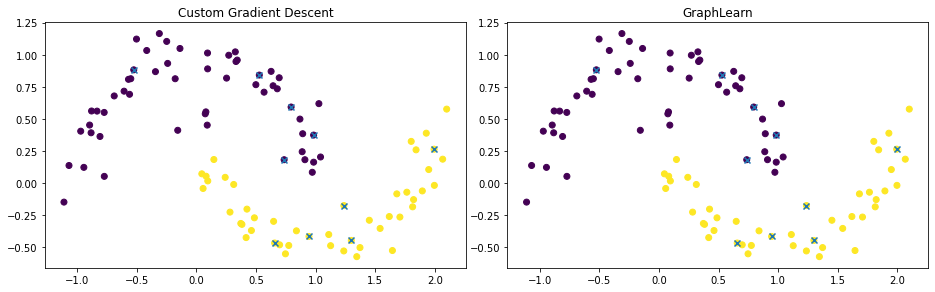

In [11]:
n = 100
k = 2
p = 2
fig, ax = plt.subplots(ncols = 2, figsize = (13, 4))
fig.tight_layout()

# Generate training data and label sets
X,labels = datasets.make_moons(n_samples=n,noise=0.1)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]
m = train_ind.size

y = np.zeros((m, k))
for i in range(train_ind.size):
    y[i] = euclidean_basis(train_labels[i], k)
    
# Custom Gradient Descent
my_u = gradient_ppoisson(W, train_ind, y, p = 2)
my_pred_labels = predict(my_u)

ax[0].scatter(X[:,0],X[:,1], c=my_pred_labels)
ax[0].scatter(X[train_ind,0],X[train_ind,1], marker='x')
ax[0].set_title("Custom Gradient Descent")

# Using graph learning toolkit
train_labels = labels[train_ind]

model = gl.ssl.poisson(W, solver='gradient_descent')
u = model.fit(train_ind, train_labels)
pred_labels = predict(u)
ax[1].scatter(X[:,0],X[:,1], c=pred_labels)
ax[1].scatter(X[train_ind,0],X[train_ind,1], marker='x')
ax[1].set_title("GraphLearn")

print("Energy of GraphLearning Solution:", penergy(u.flatten(), W, train_ind, y, p))
print("Energy of custom solution:", penergy(my_u.flatten(), W, train_ind, y, p))
print("Accuracy of custom solution:", gl.ssl.ssl_accuracy(my_pred_labels, labels, len(train_ind)))
print("Accuracy of GraphLearn solution:", gl.ssl.ssl_accuracy(pred_labels, labels, len(train_ind)))
print("Number of different predictions", np.count_nonzero(my_pred_labels - pred_labels))

plt.show()

## Comparing gradient descent solution for varying values of p

In [3]:
n = 200
k = 2
p_vals = [[2, 4], [8, 16], [32, 64]] + [[100 + 10 * i, 105 + 10 * i]  for i in range(0,10)] + [[200 + 2*i, 201 + 2*i] for i in range(0, 100)]
print(p_vals)
solutions = {} # Stores the values of the solution for different p

# Generate training data and label sets
X,labels = datasets.make_moons(n_samples=n,noise=0.1, random_state = 0)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]
m = train_ind.size

y = np.zeros((m, k))
for i in range(train_ind.size):
    y[i] = euclidean_basis(train_labels[i], k)

model = gl.ssl.poisson(W, solver='gradient_descent')
u = model.fit(train_ind, train_labels)
pred_labels = predict(u)

[[2, 4], [8, 16], [32, 64], [100, 105], [110, 115], [120, 125], [130, 135], [140, 145], [150, 155], [160, 165], [170, 175], [180, 185], [190, 195], [200, 201], [202, 203], [204, 205], [206, 207], [208, 209], [210, 211], [212, 213], [214, 215], [216, 217], [218, 219], [220, 221], [222, 223], [224, 225], [226, 227], [228, 229], [230, 231], [232, 233], [234, 235], [236, 237], [238, 239], [240, 241], [242, 243], [244, 245], [246, 247], [248, 249], [250, 251], [252, 253], [254, 255], [256, 257], [258, 259], [260, 261], [262, 263], [264, 265], [266, 267], [268, 269], [270, 271], [272, 273], [274, 275], [276, 277], [278, 279], [280, 281], [282, 283], [284, 285], [286, 287], [288, 289], [290, 291], [292, 293], [294, 295], [296, 297], [298, 299], [300, 301], [302, 303], [304, 305], [306, 307], [308, 309], [310, 311], [312, 313], [314, 315], [316, 317], [318, 319], [320, 321], [322, 323], [324, 325], [326, 327], [328, 329], [330, 331], [332, 333], [334, 335], [336, 337], [338, 339], [340, 341], 

########### Gradient Descent (w/ Jacobian) for p = 2
Energy = -82.62
Discrepancies = 0
Accuracy = 93.68%
Runtime = 1.52 min
########### Gradient Descent (w/ Jacobian) for p = 4
Energy = -47.12
Discrepancies = 17
Accuracy = 84.74%
Runtime = 9.44 min
########### Gradient Descent (w/ Jacobian) for p = 8
Energy = -42.21
Discrepancies = 20
Accuracy = 83.16%
Runtime = 9.34 min
########### Gradient Descent (w/ Jacobian) for p = 16
Energy = -38.68
Discrepancies = 21
Accuracy = 82.63%
Runtime = 9.39 min
########### Gradient Descent (w/ Jacobian) for p = 32
Energy = -36.99
Discrepancies = 20
Accuracy = 83.16%
Runtime = 9.60 min
########### Gradient Descent (w/ Jacobian) for p = 64
Energy = -19.16
Discrepancies = 20
Accuracy = 83.16%
Runtime = 9.31 min
########### Gradient Descent (w/ Jacobian) for p = 100
Energy = 2147.01
Discrepancies = 20
Accuracy = 83.16%
Runtime = 0.07 min
########### Gradient Descent (w/ Jacobian) for p = 105
Energy = 4434.17
Discrepancies = 20
Accuracy = 83.16%
Runtime = 0

########### Gradient Descent (w/ Jacobian) for p = 236
Energy = 2235682870284.95
Discrepancies = 20
Accuracy = 83.16%
Runtime = 0.04 min
########### Gradient Descent (w/ Jacobian) for p = 237
Energy = 2614841102243.50
Discrepancies = 20
Accuracy = 83.16%
Runtime = 0.04 min
########### Gradient Descent (w/ Jacobian) for p = 238
Energy = 3058382597735.29
Discrepancies = 20
Accuracy = 83.16%
Runtime = 0.05 min
########### Gradient Descent (w/ Jacobian) for p = 239
Energy = 3577252663244.09
Discrepancies = 20
Accuracy = 83.16%
Runtime = 0.04 min
########### Gradient Descent (w/ Jacobian) for p = 240
Energy = 4184259338309.42
Discrepancies = 20
Accuracy = 83.16%
Runtime = 0.04 min
########### Gradient Descent (w/ Jacobian) for p = 241
Energy = 4894390725121.42
Discrepancies = 20
Accuracy = 83.16%
Runtime = 0.04 min
########### Gradient Descent (w/ Jacobian) for p = 242
Energy = 5725186428522.14
Discrepancies = 20
Accuracy = 83.16%
Runtime = 0.04 min
########### Gradient Descent (w/ Jacobian

/home/user/.local/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:137: RuntimeWarning: overflow encountered in power
  fx = fun(np.copy(x), *args)
/home/user/.local/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:137: RuntimeWarning: invalid value encountered in multiply
  fx = fun(np.copy(x), *args)
/tmp/ipykernel_23289/64551659.py:18: RuntimeWarning: overflow encountered in power
  energy = np.around(penergy(my_u.flatten(), W, train_ind, y, p), 2)
/tmp/ipykernel_23289/64551659.py:18: RuntimeWarning: invalid value encountered in multiply
  energy = np.around(penergy(my_u.flatten(), W, train_ind, y, p), 2)


########### Gradient Descent (w/ Jacobian) for p = 246
Energy = nan
Discrepancies = 20
Accuracy = 83.16%
Runtime = 0.07 min
########### Gradient Descent (w/ Jacobian) for p = 247
Energy = nan
Discrepancies = 20
Accuracy = 83.16%
Runtime = 0.07 min


/home/user/.local/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:164: RuntimeWarning: overflow encountered in power
  return np.atleast_1d(grad(np.copy(x), *args))
/home/user/.local/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:164: RuntimeWarning: invalid value encountered in multiply
  return np.atleast_1d(grad(np.copy(x), *args))


ValueError: array must not contain infs or NaNs

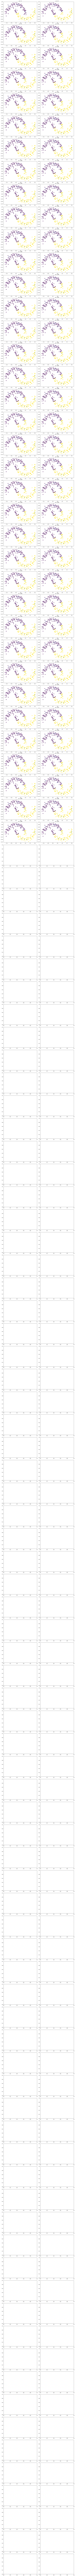

In [4]:
fig, ax = plt.subplots(nrows = len(p_vals), ncols = len(p_vals[0]), figsize = (13, 4*len(p_vals)))
fig.tight_layout()

my_u = u

# Run and plot for varying p
for i in range(len(p_vals)):
    for j in range(len(p_vals[i])):
        start_time = time.time()

        p = p_vals[i][j]

        my_u = gradient_ppoisson(W, train_ind, y, p, start = my_u.flatten())
        my_pred_labels = predict(my_u)

        discrepancies = np.count_nonzero(my_pred_labels - pred_labels)
        accuracy = gl.ssl.ssl_accuracy(my_pred_labels, labels, len(train_ind))
        energy = np.around(penergy(my_u.flatten(), W, train_ind, y, p), 2)
        end_time = time.time()
        minutes = (end_time - start_time)/60
        
        info_str = f"########### Gradient Descent (w/ Jacobian) for p = {p}\n"\
                        f"Energy = {energy:.2f}\n"\
                        f"Discrepancies = {discrepancies}"\
                        f"\nAccuracy = {accuracy:.2f}%\n"\
                        f"Runtime = {minutes:.2f} min"

        print(info_str)
        
        solutions[p] = my_u
        
        ax[i, j].scatter(X[:,0],X[:,1], c=my_pred_labels)
        ax[i, j].scatter(X[train_ind,0],X[train_ind,1], marker='x', label = "Labeled nodes")
        ax[i, j].set_title(f"p = {p}")

plt.legend()
plt.show()

In [ ]:
# Comparison of the two "hessians"
n = 20
p = 12

X,labels = datasets.make_moons(n_samples=n,noise=0.1)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]
model = gl.ssl.poisson(W, solver='gradient_descent')
u = model.fit(train_ind, train_labels)
u_flattened = u.flatten()

vectorized_hess = vectorized_hessian(u_flattened, W, train_ind, y, p)
hess = hessian(u_flattened, W, train_ind, y, p)
print(vectorized_hess)
print(hess)
print(vectorized_hess - hess)

[[ 3.71384521e+02 -3.99953881e+02 -2.26238059e-01 ...  1.10221656e-03
  -2.11502063e-07 -1.50474923e-07]
 [-3.99953881e+02  3.71384521e+02  5.97013178e-02 ... -6.98187725e-04
  -1.50474923e-07 -2.11502063e-07]
 [-2.26238059e-01 -5.97013178e-02  1.87121577e+03 ...  5.62930526e-01
  -2.89334411e-04 -2.61699745e-04]
 ...
 [-1.10221656e-03 -6.98187725e-04 -5.62930526e-01 ...  1.98905268e+02
  -4.78763093e-01 -6.03228467e-01]
 [-2.11502063e-07  1.50474923e-07 -2.89334411e-04 ...  4.78763093e-01
   6.39248202e+01 -5.46512446e+01]
 [ 1.50474923e-07 -2.11502063e-07  2.61699745e-04 ... -6.03228467e-01
  -5.46512446e+01  6.39248202e+01]]
[[8700.26250691 8700.26250691 8700.26250691 ... 8700.26250691
  8700.26250691 8700.26250691]
 [8700.26250691 8700.26250691 8700.26250691 ... 8700.26250691
  8700.26250691 8700.26250691]
 [8700.26250691 8700.26250691 8700.26250691 ... 8700.26250691
  8700.26250691 8700.26250691]
 ...
 [8700.26250691 8700.26250691 8700.26250691 ... 8700.26250691
  8700.26250691 87

In [ ]:
# Example
y = np.array([[1,0], [0,1]])
W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
idx = [0, 1]
n = 3
k = 2
m = 2
p = 3
u = np.random.random(size = (n,k))

print(vectorized_jacobian(u.flatten(), W, idx, y, p))

r = s = 0
gradu = grad(u)
y_bar = y.sum(axis = 0)/m
print(vectorized_jacobian(u.flatten(), W, idx, y, p).shape)
print(u.flatten().shape)
scipy.optimize.check_grad(penergy, vectorized_jacobian, u.flatten(), W, idx, y, p)

ran vectorized-jacobian
[-0.35066744  0.66432022  0.05410191 -0.7255464   0.29656554  0.06122618]
ran vectorized-jacobian
(6,)
(6,)
ran vectorized-jacobian


2.259047967398693e-08